In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

### <font color=blue> Prep data. Choose deaths transformation.

In [2]:
from epsampling.modeling import get_full_modeling_dfs

df, df_acs = get_full_modeling_dfs(timestamp='20241009-144131')

# df = df[df.True_inc_deaths > 0]

df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop * 100000, axis=1)
df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop * 100000, axis=1)
df['State'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop * 100000, axis=1)
df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop * 100000, axis=1)

### <font color=blue> Do subset where true deaths is more than 0?

In [3]:
# df = df[df.True_inc_deaths > 0]

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# df['Target'].describe(), df['Naive'].describe()

### <font color=blue> Run models.

In [4]:
def line_plot(df, x_col, y_col, title=None):

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.regplot(data=df, x=x_col, y=y_col, 
                scatter_kws={'s':10, 'alpha':0.5}, 
                line_kws={'color':'k','linewidth':0.5},logx=False)
    
    if title is not None:
        plt.title(title) 

    plt.show()





============ TEST MONTH 14 ============

 > Deaths_Lasso
  • MAE: 	2.37845
  • MedAE: 	1.58565
  • MSE: 	17.97242
  • RMSE: 	4.23939
  • r-squared: 	0.98926
  • relMAE: 	2.8407
  • relMedAE: 	1.88323
 > Deaths_naive
  • MAE: 	1.892
  • MedAE: 	0.8142
  • MSE: 	18.02574
  • RMSE: 	4.24567
  • r-squared: 	0.98923
  • relMAE: 	1.0
  • relMedAE: 	1.0


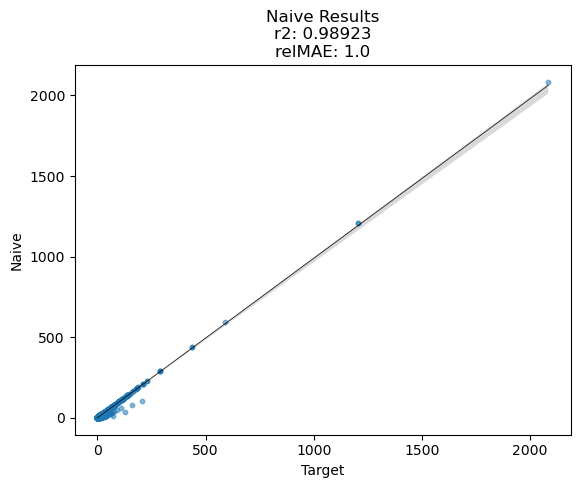

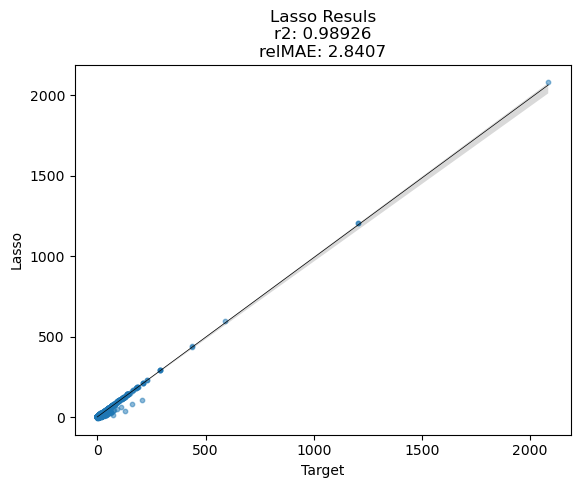





============ TEST MONTH 12 ============

 > Deaths_Lasso
  • MAE: 	1.88443
  • MedAE: 	1.60611
  • MSE: 	8.03018
  • RMSE: 	2.83376
  • r-squared: 	0.99674
  • relMAE: 	3682241581260.252
  • relMedAE: 	2.26205
 > Deaths_naive
  • MAE: 	1.25757
  • MedAE: 	0.69364
  • MSE: 	7.33973
  • RMSE: 	2.70919
  • r-squared: 	0.99702
  • relMAE: 	0.99722
  • relMedAE: 	1.0


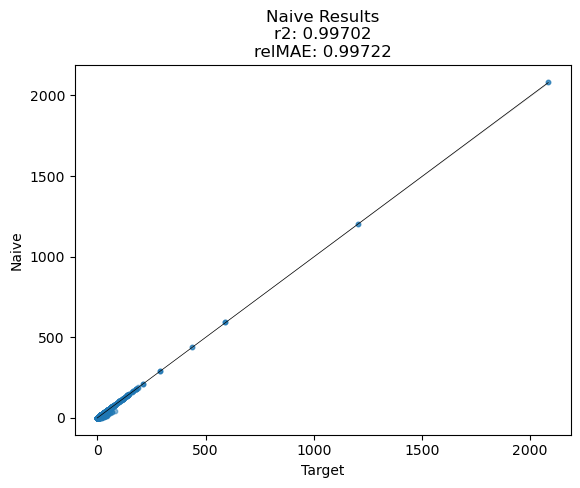

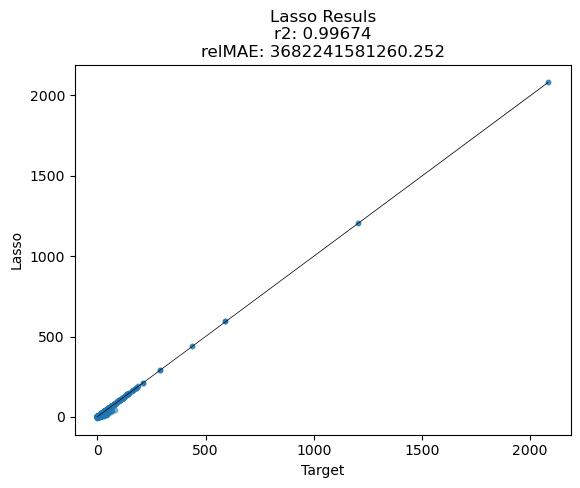

In [5]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
random.seed(666)

# # # # # # # # # # # # # # # # # # # #
num_runs = 4
alg = 'Lasso'
data_frac = 0.5
# # # # # # # # # # # # # # # # # # # #

chunks = get_chunks(list(df.Date.unique()), num_runs)

## Pre-selected test-train splits to product a good mae and a bad mae
# idc = random.sample(range(len(chunks)), num_runs)
idc = [14,12]

for idx in idc:
    
    ########## RUN MODEL ########## 
    
    df_train, df_test = get_date_chunked_splits(df, chunks, 
                                                idx, samp_frac=data_frac)
    
    feats = list(df_acs.columns) + ['State','Cumtm1','Naive',
                                    'State_pop','Ratio','Pop']
        
    X_train = df_train[feats]
    X_test = df_test[feats]

    y_train = df_train['Target']
    y_test = df_test['Target']
    y_naive = df_test['Naive']
    
    if alg=='Linear':
        reg = LinearRegression().fit(X_train, y_train)
    elif alg=='Lasso':
        reg = Lasso(alpha=0.5).fit(X_train, y_train)

    df_test[alg] = reg.predict(X_test)
    
    
    ########## GET METRICS ##########

    model_names = [f'Deaths_{alg}', 'Deaths_naive']
    model_preds = [df_test[alg], df_test['Naive']]

    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)

    print(f'\n\n\n\n============ TEST MONTH {idx} ============\n')
    for k,v in metrics_dict.items():
        print(f' > {k}')
        for k2,v2 in v.items():
            if k2=='r2':
                k3 = 'r-squared'
            else:
                k3 = k2
            print(f'  • {k3}: \t{round(v2,5)}')
            
            
   ########## PLOTS ########## 
            
    ## Naive plot
    r2 = round(metrics_dict['Deaths_naive']['r2'],5)
    relmae = round(metrics_dict['Deaths_naive']['relMAE'],5)
    line_plot(df_test, 'Target', 'Naive', 
              title=f'Naive Results\nr2: {r2}\nrelMAE: {relmae}')
    
    ## Regression plot
    r2 = round(metrics_dict[f'Deaths_{alg}']['r2'],5)
    relmae = round(metrics_dict[f'Deaths_{alg}']['relMAE'],5)
    line_plot(df_test, 'Target', f'{alg}', 
              title=f'{alg} Resuls\nr2: {r2}\nrelMAE: {relmae}')

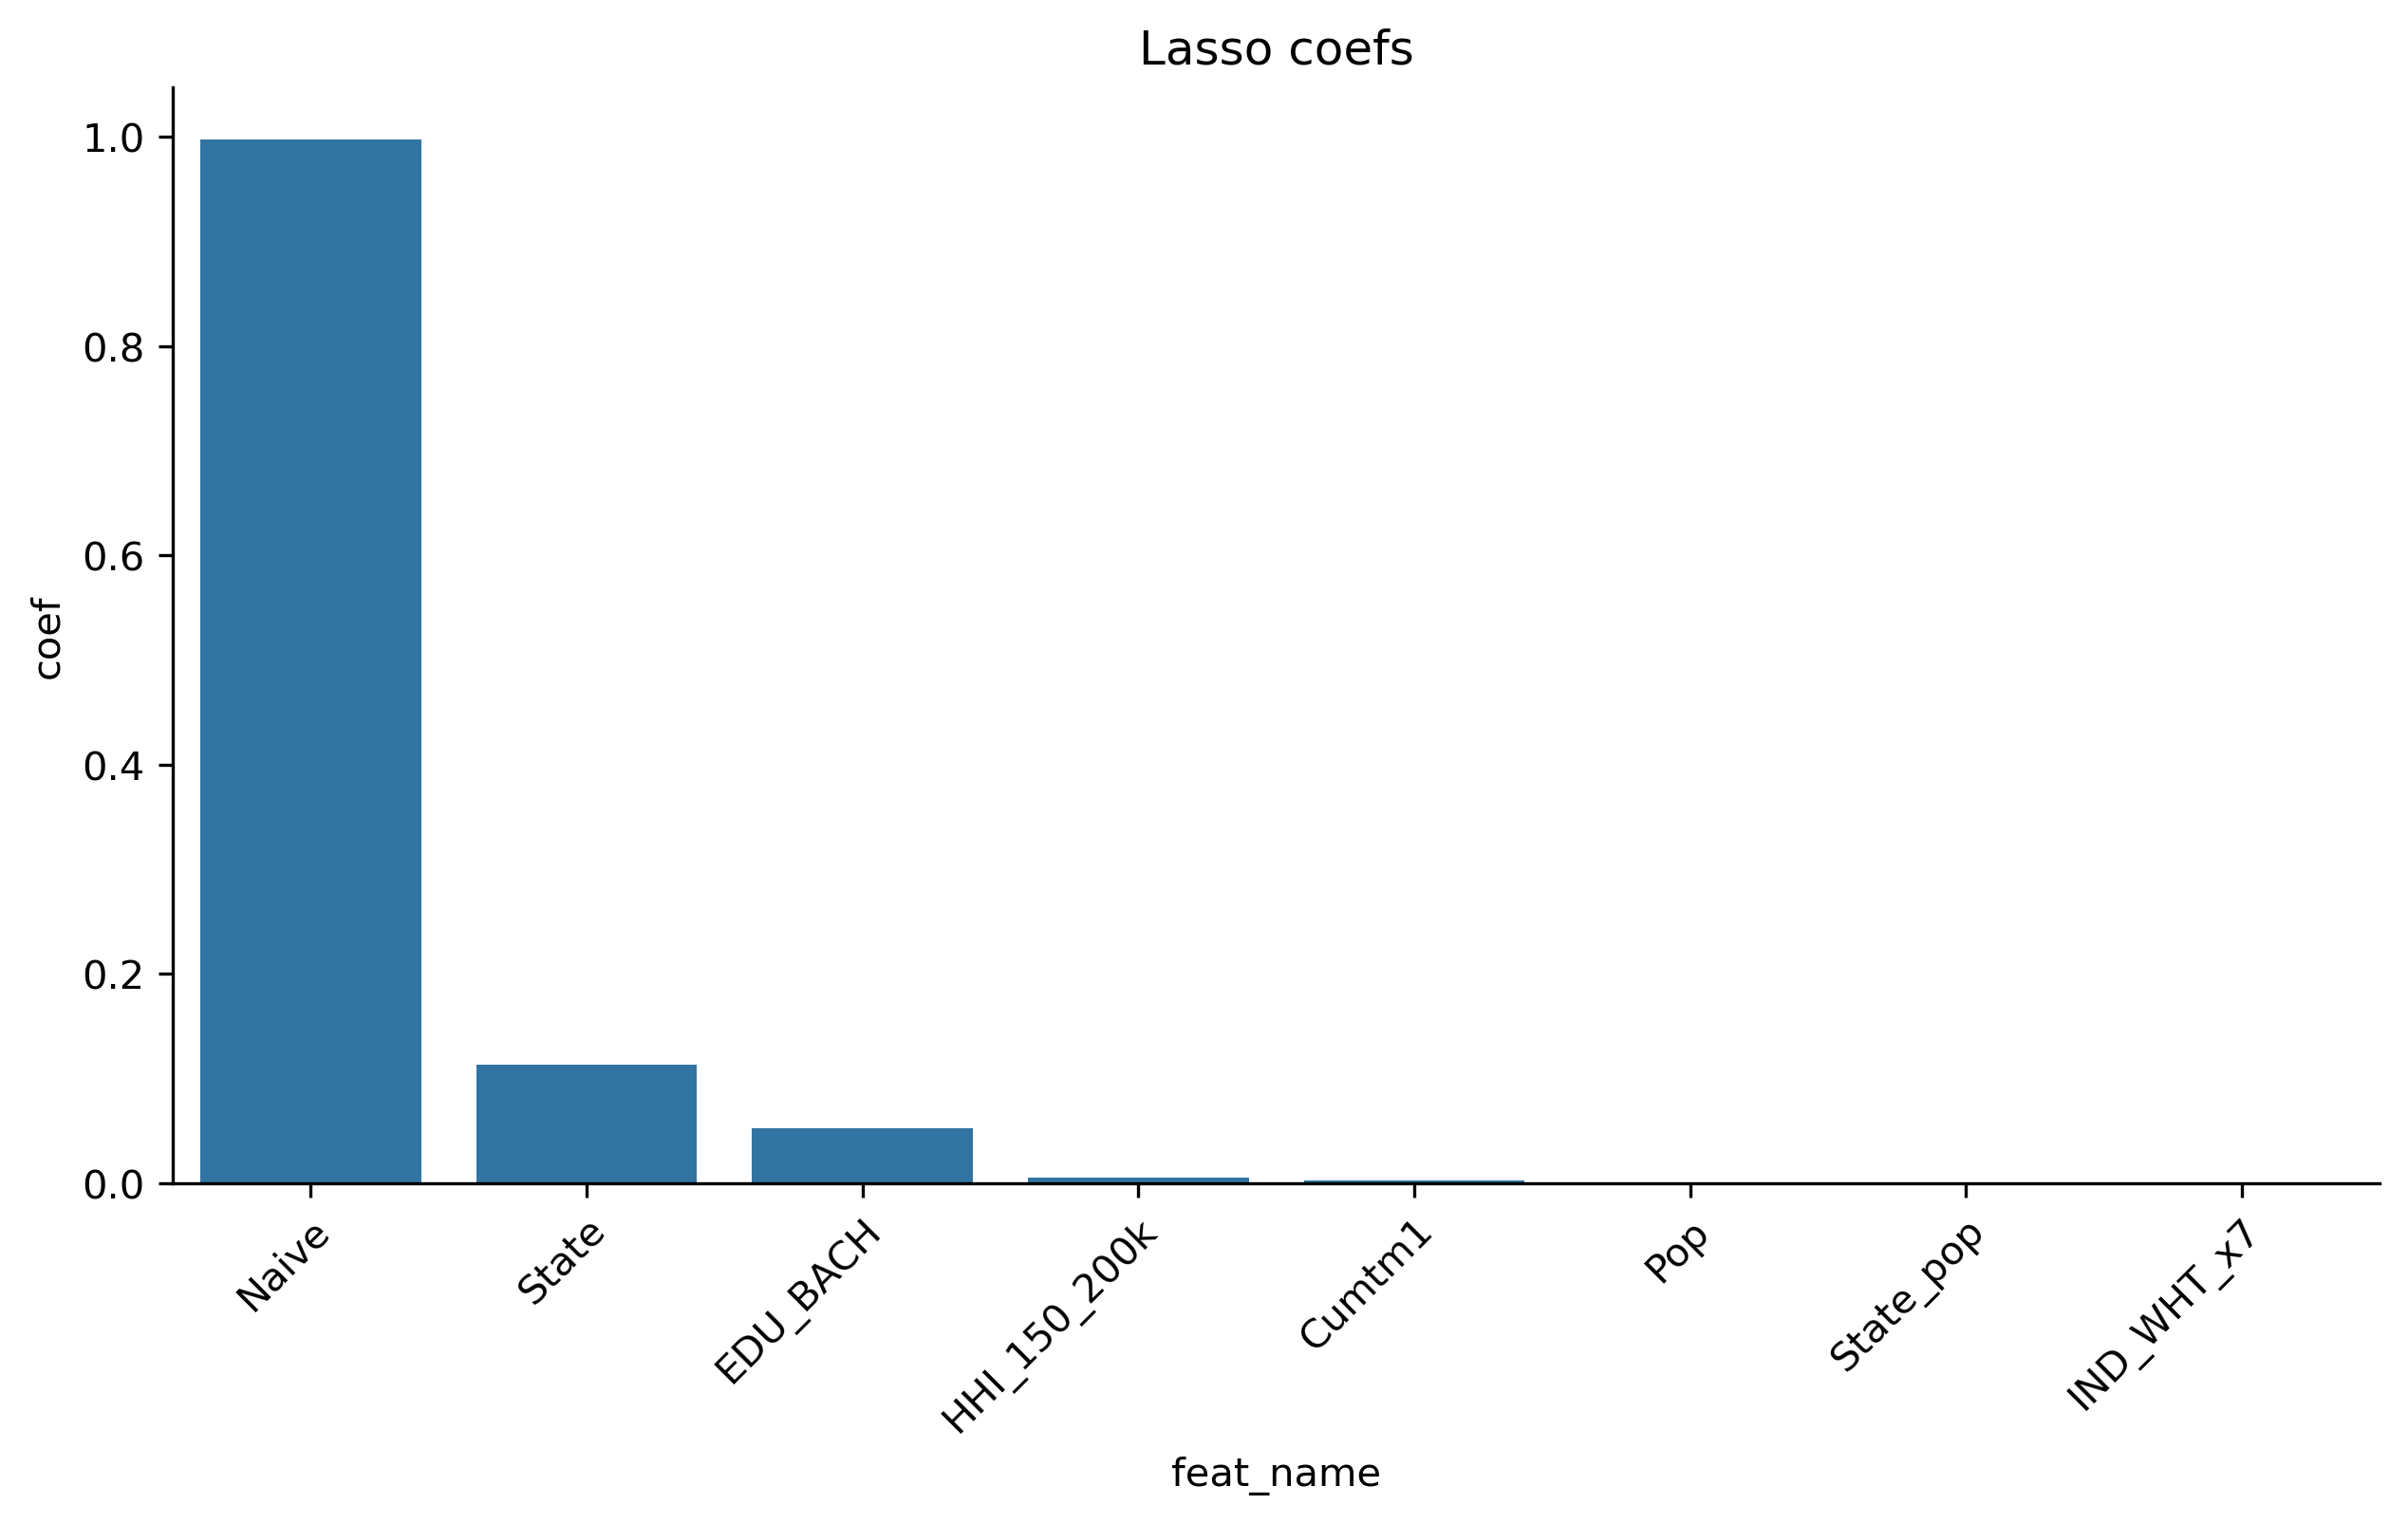

In [6]:
# # # # # # # # # #
how_many = 8
# # # # # # # # # #

coef = abs(reg.coef_)
ind = np.argpartition(coef, -how_many)[-how_many:]
top = coef[ind]

df_coefs = X_train.iloc[:, ind]
which_feats = df_coefs.columns

res_df = pd.DataFrame([top, which_feats], index=['coef','feat_name'])
res_df = res_df.T.sort_values(by='coef',inplace=False,ascending=False)
res_df = res_df[:how_many]

import seaborn as sns
import matplotlib.pyplot as plt


DPI = 300

plt.figure(figsize=(10,5))
sns.barplot(res_df, y="coef", x="feat_name", legend=False)
plt.title(f'{alg} coefs')
# plt.xticks(xticks, rotation=45)
plt.xticks(rotation=45,ha='right',wrap='True')

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()